# Import lib

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# The latest CDF library https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/latest/
from spacepy import pycdf

# os.environ["CDF_LIB"] = "C:\\Program Files\\CDF_Distribution\\cdf39_0-dist\\lib"
os.environ["CDF_LIB"] = "/Applications/cdf/cdf39_0-dist/lib"

# sys.path.append('../lib/')
sys.path.append('./lib/')

import juice_cdf_lib as juice_cdf

# Setting and Read CDF file

In [3]:
# *** Parameter set ***
spec_mode = 1                           # 0: low-resoltion   1: high-resolution
ave_mode = 0                            # 0: simple sum   1: FFT sum   2: median sum   3: min sum
hz_mode = 0                             # 0: sum    1: /Hz
cal_mode = 0                            # 0: raw    1: dBm＠ADC  2: V@HF   3:V2@HF   4:V2@HF
clean_mode = 0                          # 0: normal 1: noise cleaning

# E_power_min = 1e-4                    # E_power_min: 10e-4 (--> -144 dBm)
cal = 0                                 # 0: background   1: cal
f_max = 45000                           # f_max [kHz]
f_min = 80                              # f_min [kHz]
p_max = 8.5                             # background: 8     CAL: 10
p_min = 1.5                             # background: 2.5   CAL: 5

cf = 0.0                                # Conversion Factor: RAW
if cal_mode == 1:
    cf = -104.1                         # dBm @ ADC 
elif cal_mode == 2:
    cf = -104.1 - 10.00 - 15.0          # V(amplitude) @ HF -- in EM2-1: HF-gain +15dB, ADC: 2Vpp  ==> EM2-3 & later: same [-6dB + 6dB]
elif cal_mode == 3:
    cf = -104.1 - 13.01 - 15.0          # V^2 @ HF (EM2-0 case)
elif cal_mode == 4:
    cf = -104.1 - 13.01 - 15.0 - 5.0    # V^2 @ RWIin -- temporary
"""
******************************************************
[EM2-0]
"1-bit" = -104.1 dBm = -114.1 dB V  = 1.97E-6 V    ==> "20-bit": 2.06 Vpp
"HF input"  +15dB(AMP) -3dB(50-ohm) = "+12dB"      ==> "1-bit": 5E-7 V,  Full: 0.5 Vpp
******************************************************
[EM2-3]
"1-bit" = -110.1 dBm = -110.1 dB V  = 0.99E-7 V "  ==> "20-bit": 1.03 Vpp
"HF input"  +9dB(AMP)  -3dB(50-ohm受け) = "+6dB"    ==> "1-bit": 5E-7 V,  Full: 0.5 Vpp
******************************************************
"""

p_max = p_max + cf/10
p_min = p_min + cf/10
if hz_mode == 1:
    p_max = p_max - 5.0
    p_min = p_min - 5.0
else:
    if spec_mode == 1:
        p_max = p_max - 1.5
        p_min = p_min - 1.5

# *** Folder set ***
work_dir = '/Users/user/0-python/JUICE_notebook/ql/'   # Plot dump folder
data_dir = '/Users/user/0-python/JUICE_GS_test/cdf/'   # Data folder

In [4]:
# *** NECP ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230419T135849-20230419T141229_V01___RPR1_52000000_2023.109.16.17.21.607.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230419T141231-20230419T141402_V01___RPR1_52000001_2023.109.17.51.54.600.cdf'

# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100927-20230530T100937_V01___RPR1_52000011_2023.150.10.41.53.508.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T120759-20230601T120857_V01___RPR1_52000015_2023.152.12.32.12.471.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T121435-20230601T121533_V01___RPR1_52000016_2023.152.13.14.38.473.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122138-20230601T122236_V01___RPR1_52000017_2023.152.13.55.02.539.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122707-20230601T122805_V01___RPR1_52000018_2023.152.14.35.37.467.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T123416-20230601T123514_V01___RPR1_52000019_2023.152.15.15.55.483.cdf'

data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T090434-20230712T093848_V01___RPR1_52000001_2023.193.10.24.57.479.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T093942-20230712T101355_V01___RPR1_52000002_2023.194.08.38.36.474.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T101449-20230712T104147_V01___RPR1_52000003_2023.194.10.18.44.478.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T104149-20230712T232406_V01___RPR1_52000004_2023.194.11.15.35.498.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T232408-20230712T235156_V01___RPR1_52000005_2023.195.09.10.17.486.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T235158-20230713T001854_V01___RPR1_52000006_2023.195.10.28.57.506.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T001856-20230713T004644_V01___RPR1_52000007_2023.195.11.42.37.540.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T004648-20230713T011342_V01___RPR1_52000008_2023.195.12.39.02.479.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T011436-20230713T014134_V01___RPR1_52000009_2023.195.13.03.08.470.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T014136-20230713T020924_V01___RPR1_5200000A_2023.195.13.25.22.477.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T020928-20230713T023718_V01___RPR1_5200000B_2023.195.13.47.46.500.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T023720-20230713T030416_V01___RPR1_5200000C_2023.195.14.10.35.574.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T030510-20230713T033208_V01___RPR1_5200000D_2023.195.14.33.20.470.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T033210-20230713T040000_V01___RPR1_5200000E_2023.195.14.55.41.474.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T040002-20230713T042751_V01___RPR1_5200000F_2023.195.15.18.00.472.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T042753-20230713T045449_V01___RPR1_52000010_2023.195.15.40.11.470.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T045543-20230713T050917_V01___RPR1_52000011_2023.195.16.14.20.468.cdf'

# *** High-samp rate ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000304-20000101T000308_V01___TMIDX_00000_32.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000150-20000101T000154_V01___TMIDX_00000_64.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000355-20000101T000359_V01___TMIDX_00000_96.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000555-20000101T000559_V01___TMIDX_00000_128.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000725-20000101T000730_V01___TMIDX_00000_256.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000131-20000101T000139_V01___TMIDX_00000_512.bin.cdf'
#
# data_name = 'bad_NEW_PROCESSING_JUICE_L1a_RPWI-HF-SID2_20000101T000114-20000101T000210_V01___TMIDX_00000.bin.cdf'

# *** High-samp rate: Tsuchiya ***
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000050-20000101T000454_V01___HF_SID2_032_20230624-1132.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000031-20000101T000940_V01___HF_SID2_064_20230624-1139.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000111-20000101T000150_V01___HF_SID2_128_20230624-1306.ccs.cdf'

# *** Ver.2 ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000459-20000101T000700_V01___HF_20210920-1007.ccs.cdf'

cdf_file = data_dir + data_name
# %ls $data_dir
%ls $cdf_file

/Users/user/0-python/JUICE_GS_test/cdf/JUICE_L1a_RPWI-HF-SID2_20230712T090434-20230712T093848_V01___RPR1_52000001_2023.193.10.24.57.479.cdf


# get SID-2 data

In [5]:
cdf = pycdf.CDF(cdf_file)
data = juice_cdf.juice_getdata_hf_sid02(cdf)

# Raw data

2023/07/12


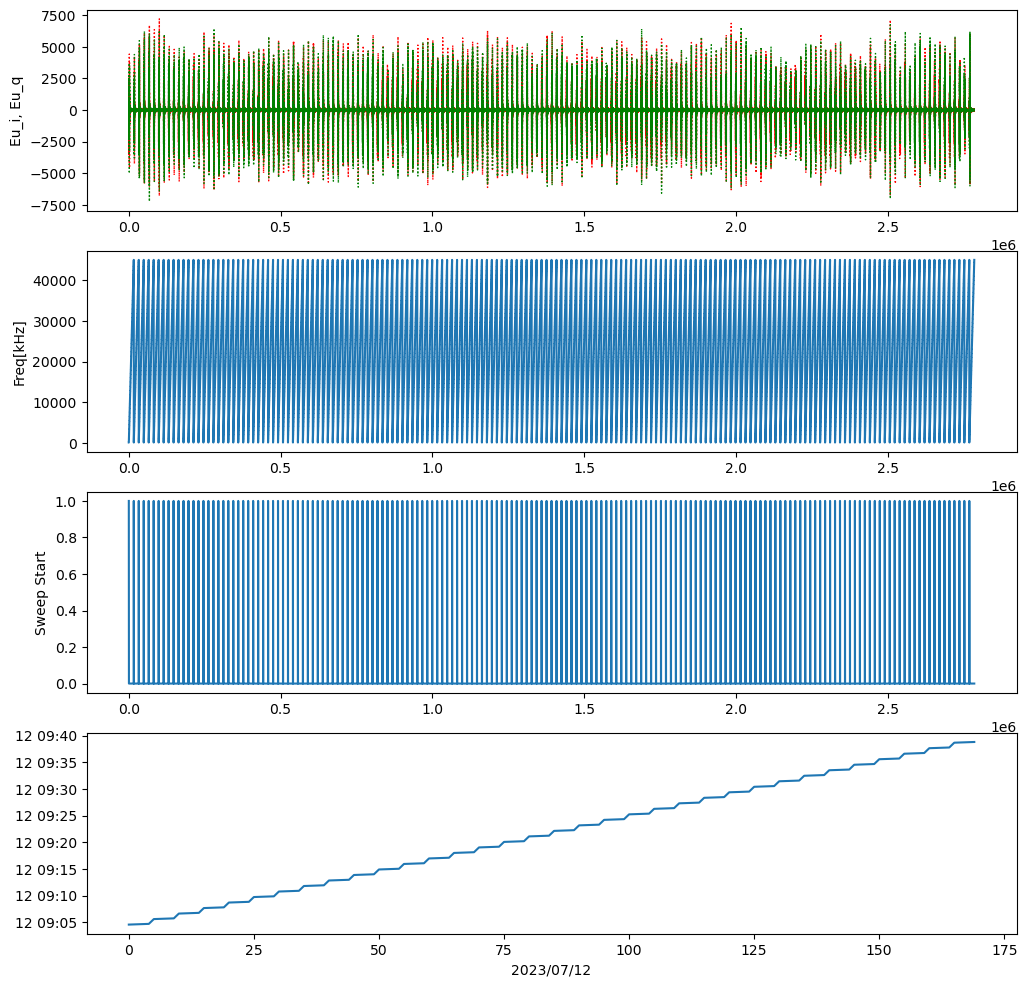

In [6]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(data.Eu_i), '-r', linewidth=1)
ax1.plot(np.ravel(data.Eu_q), '-g', linewidth=1)
ax1.plot(np.ravel(data.Ev_i), '--r', linewidth=1)
ax1.plot(np.ravel(data.Ev_q), '--g', linewidth=1)
ax1.plot(np.ravel(data.Ew_i), ':r', linewidth=1)
ax1.plot(np.ravel(data.Ew_q), ':g', linewidth=1)
ax2.plot(np.ravel(data.frequency))
ax3.plot(np.ravel(data.sweep_start))
ax4.plot(np.ravel(data.epoch))
#
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
print(date)

ax1.set_ylabel('Eu_i, Eu_q')
ax2.set_ylabel('Freq[kHz]')
ax3.set_ylabel('Sweep Start')
ax4.set_xlabel(date)

plt.show()
png_fname = work_dir+data_name+'_raw.png'
# fig.savefig(png_fname)


In [7]:
# Sped mode:  0 - low resolution,  1 - high resolution  
spec = juice_cdf.juice_getspec_hf_sid02(data, spec_mode, hz_mode, ave_mode)
power_str = juice_cdf.power_label(cal_mode, hz_mode)

if clean_mode > 0:                          # 0: normal 1: noise cleaning
    spec.Eu_power = juice_cdf.clean_rfi(spec.Eu_power, 7)
    spec.Ev_power = juice_cdf.clean_rfi(spec.Ev_power, 7)
    spec.Ew_power = juice_cdf.clean_rfi(spec.Ew_power, 7)

spec.Eu_power = spec.Eu_power * 10**(cf/10)
spec.Ev_power = spec.Ev_power * 10**(cf/10)
spec.Ew_power = spec.Ew_power * 10**(cf/10)

freq_ave = np.mean(spec.frequency, axis=1)
Eu_ave = np.mean(spec.Eu_power, axis=1)
Ev_ave = np.mean(spec.Ev_power, axis=1)
Ew_ave = np.mean(spec.Ew_power, axis=1)

freq_med = np.median(spec.frequency, axis=1)
Eu_med = np.median(spec.Eu_power, axis=1)
Ev_med = np.median(spec.Ev_power, axis=1)
Ew_med = np.median(spec.Ew_power, axis=1)

n_time = spec.Eu_power.shape[1]
n_freq = spec.Eu_power.shape[0]


# Spectra

# LOG: Frequency - Power

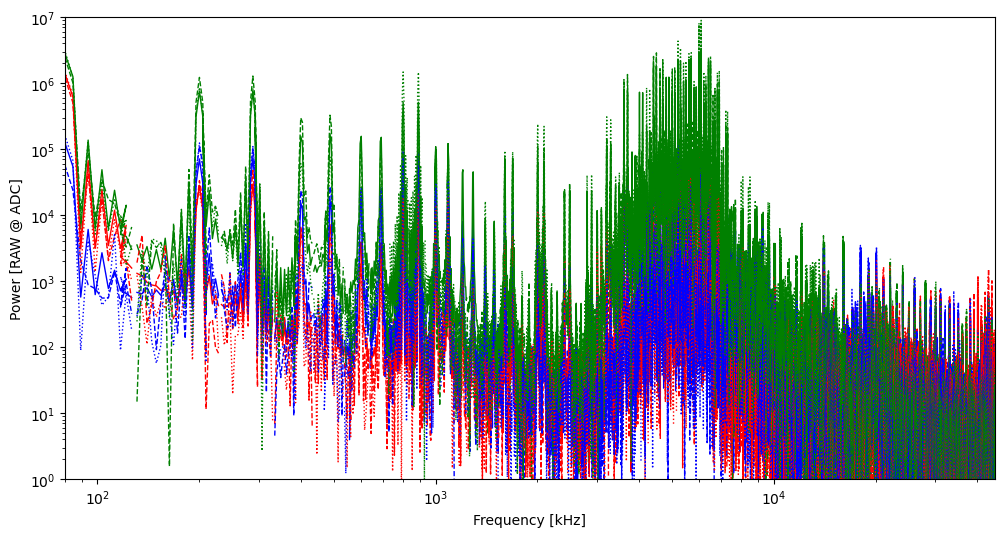

In [8]:
fig = plt.figure(figsize=(12, 6))

if spec_mode == 0:
    plt.plot(freq_ave, Eu_ave, '-r', linewidth=1)
    plt.plot(freq_ave, Ev_ave, '-b', linewidth=1)
    plt.plot(freq_ave, Ew_ave, '-g', linewidth=1)
    plt.plot(spec.frequency[:,0], spec.Eu_power[:,0], '--r', linewidth=1)
    plt.plot(spec.frequency[:,0], spec.Ev_power[:,0], '--b', linewidth=1)
    plt.plot(spec.frequency[:,0], spec.Ew_power[:,0], '--g', linewidth=1)
    plt.plot(spec.frequency[:,n_time-1], spec.Eu_power[:,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[:,n_time-1], spec.Ev_power[:,n_time-1], ':b', linewidth=1)
    plt.plot(spec.frequency[:,n_time-1], spec.Ew_power[:,n_time-1], ':g', linewidth=1)
else:
    n_samp = np.int16(spec.n_samp * 1.9)
    n_samp = np.int16(spec.n_samp * 0.75)
    n_samp = np.int16(spec.n_samp * 0.66)
    for i in range(spec.n_step):
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Eu_ave[i*n_samp:(i+1)*n_samp], '-r', linewidth=1)
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ev_ave[i*n_samp:(i+1)*n_samp], '-b', linewidth=1)
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ew_ave[i*n_samp:(i+1)*n_samp], '-g', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Eu_power[i*n_samp:(i+1)*n_samp,0], '--r', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ev_power[i*n_samp:(i+1)*n_samp,0], '--b', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ew_power[i*n_samp:(i+1)*n_samp,0], '--g', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Eu_power[i*n_samp:(i+1)*n_samp,n_time-1], ':r', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ev_power[i*n_samp:(i+1)*n_samp,n_time-1], ':b', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ew_power[i*n_samp:(i+1)*n_samp,n_time-1], ':g', linewidth=1)
plt.xlabel('Frequency [kHz]')
plt.xscale('log')
plt.xlim(f_min, f_max)

plt.yscale('log')
plt.ylabel(power_str)
plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec-log_h.png'
fig.savefig(png_fname)

# Linear: Frequency - Power diagram

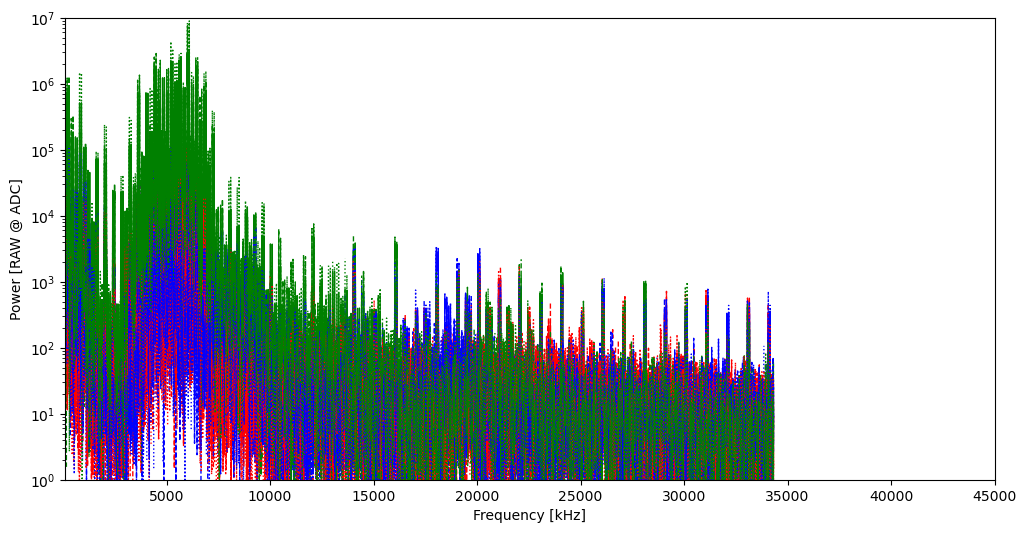

In [9]:
fig = plt.figure(figsize=(12, 6))

if spec_mode == 0:
    plt.plot(freq_ave, Eu_ave, '-r', linewidth=1)
    plt.plot(freq_ave, Ev_ave, '-b', linewidth=1)
    plt.plot(freq_ave, Ew_ave, '-g', linewidth=1)
    plt.plot(spec.frequency[:,0], spec.Eu_power[:,0], '--r', linewidth=1)
    plt.plot(spec.frequency[:,0], spec.Ev_power[:,0], '--b', linewidth=1)
    plt.plot(spec.frequency[:,0], spec.Ew_power[:,0], '--g', linewidth=1)
    plt.plot(spec.frequency[:,n_time-1], spec.Eu_power[:,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[:,n_time-1], spec.Ev_power[:,n_time-1], ':b', linewidth=1)
    plt.plot(spec.frequency[:,n_time-1], spec.Ew_power[:,n_time-1], ':g', linewidth=1)
else:
    n_samp = np.int16(spec.n_samp * 1.0)
    n_samp = np.int16(spec.n_samp * 0.75)
    n_samp = np.int16(spec.n_samp * 0.66)
    for i in range(spec.n_step):
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Eu_ave[i*n_samp:(i+1)*n_samp], '-r', linewidth=1)
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ev_ave[i*n_samp:(i+1)*n_samp], '-b', linewidth=1)
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ew_ave[i*n_samp:(i+1)*n_samp], '-g', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Eu_power[i*n_samp:(i+1)*n_samp,0], '--r', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ev_power[i*n_samp:(i+1)*n_samp,0], '--b', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ew_power[i*n_samp:(i+1)*n_samp,0], '--g', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Eu_power[i*n_samp:(i+1)*n_samp,n_time-1], ':r', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ev_power[i*n_samp:(i+1)*n_samp,n_time-1], ':b', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ew_power[i*n_samp:(i+1)*n_samp,n_time-1], ':g', linewidth=1)
plt.xlabel('Frequency [kHz]')
plt.xlim(f_min, f_max)

plt.yscale('log')
plt.ylabel(power_str)
plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h.png'
fig.savefig(png_fname)

# LOG: Frequency - Time diagram

/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/2051306637.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**(p_min+1), vmax=10**(p_max-3)), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/2051306637.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**(p_min+1), vmax=10**(p_max-3)), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel

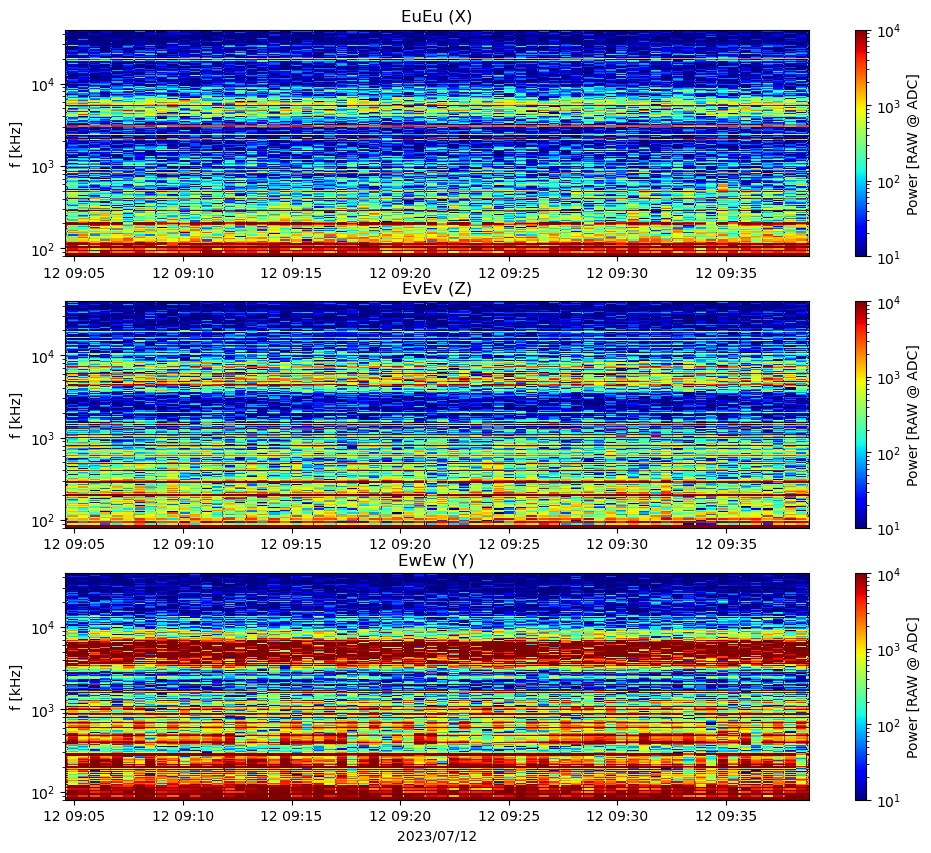

In [10]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**(p_min+1), vmax=10**(p_max-3)), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**(p_min+1), vmax=10**(p_max-3)), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**(p_min+1), vmax=10**(p_max-3)), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h.png'
fig.savefig(png_fname)


# Linear: Frequency - Time diagram

/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/1115352909.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/1115352909.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/111535290

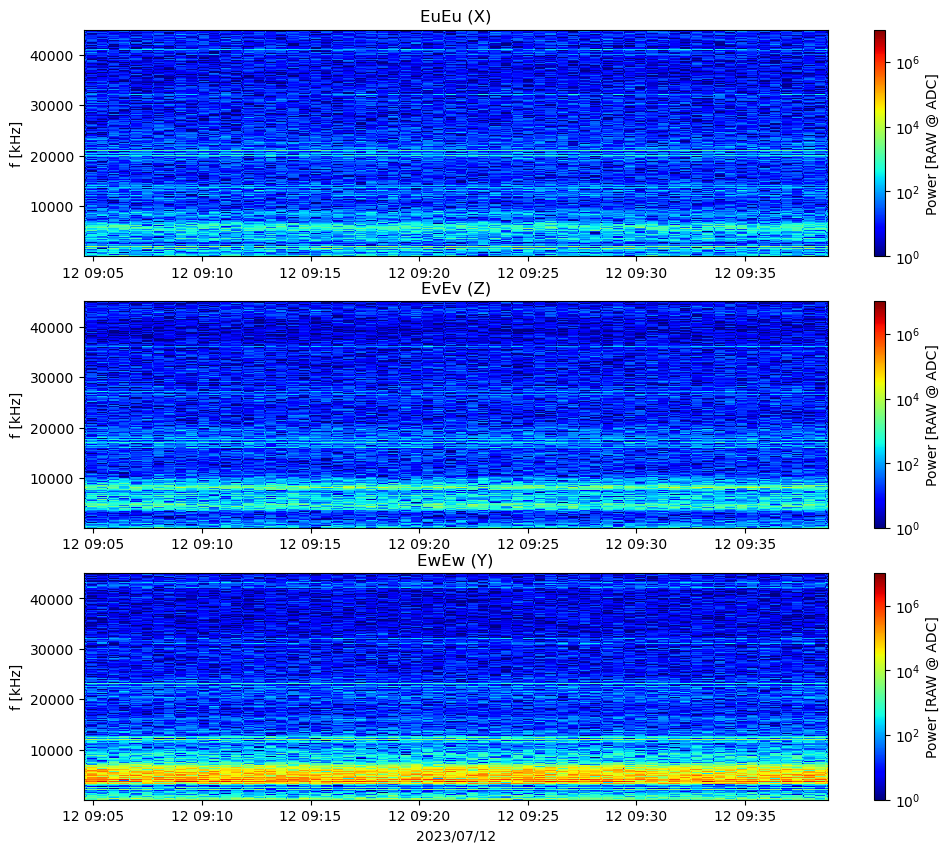

In [11]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT_h.png'
fig.savefig(png_fname)

# Analyses

In [12]:
# Antenna Effecitve Length from Fischer+ 2021
import csv

gain_dir = './lib/'
gain_name = 'juice_rwi_Effective_length_huvw_freq.csv'
gain_file = gain_dir + gain_name

with open(gain_file) as f:
    reader = csv.reader(f)
    gain_list = [row for row in reader]
gain_data = np.array(gain_list)
gain_data = gain_data.transpose()
gain_freq = np.float16(gain_data[0])*1000
gain_U = np.float16(gain_data[1]) ** 2
gain_V = np.float16(gain_data[2]) ** 2
gain_W = np.float16(gain_data[3]) ** 2

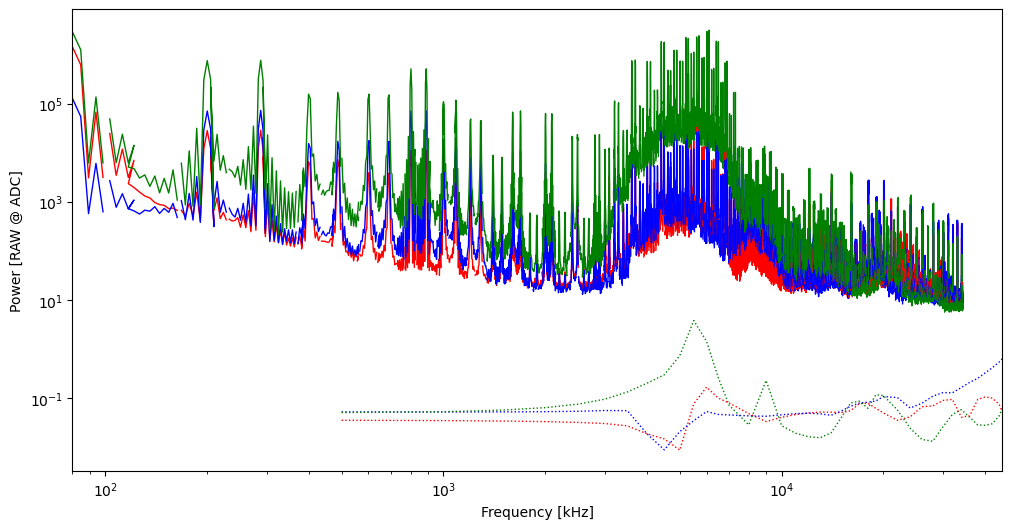

In [13]:
fig = plt.figure(figsize=(12, 6))
plt.plot(gain_freq, gain_U, ':r', linewidth=1)
plt.plot(gain_freq, gain_V, ':b', linewidth=1)
plt.plot(gain_freq, gain_W, ':g', linewidth=1)

if spec_mode == 0:
    plt.plot(freq_ave, Eu_ave, '-r', linewidth=1)
    plt.plot(freq_ave, Ev_ave, '-b', linewidth=1)
    plt.plot(freq_ave, Ew_ave, '-g', linewidth=1)
else:
    n_samp = np.int16(spec.n_samp * 1.0)
    n_samp = np.int16(spec.n_samp * 0.75)
    n_samp = np.int16(spec.n_samp * 0.66)
    for i in range(spec.n_step):
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Eu_ave[i*n_samp:(i+1)*n_samp], '-r', linewidth=1)
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ev_ave[i*n_samp:(i+1)*n_samp], '-b', linewidth=1)
        plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ew_ave[i*n_samp:(i+1)*n_samp], '-g', linewidth=1)

plt.xscale('log')
plt.xlabel('Frequency [kHz]')
plt.xlim(f_min, f_max)

plt.yscale('log')
plt.ylabel('(ANT effective length)^2')
plt.ylabel(power_str)
# plt.ylim(10**p_min, 10**p_max)
# plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_ant-gain.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_ant-gain-h.png'
# fig.savefig(png_fname)

[29.125 33.75  38.375 43.    47.625 52.25  56.875 61.5   66.125 70.75
 75.375 80.    84.625 89.25  93.875 98.5  ]
[103.125      107.75       112.375      117.         121.625
 117.03106689 121.65606689 126.28106689 130.90606689 135.53106689
 140.15606689 144.78106689 149.40606689 154.03106689 158.65606689
 163.28106689]
[167.90606689 172.53106689 177.15606689 181.78106689 186.40606689
 191.03106689 195.65606689 200.28106689 204.90606689 209.53106689
 204.93713379 209.56213379 214.18713379 218.81213379 223.43713379
 228.06213379]
[232.68713379 237.31213379 241.93713379 246.56213379 251.18713379
 255.81213379 260.43713379 265.06213379 269.68713379 274.31213379
 278.93713379 283.56213379 288.18713379 292.81213379 297.43713379
 292.84320068]
[297.46820068 302.09320068 306.71820068 311.34320068 315.96820068
 320.59320068 325.21820068 329.84320068 334.46820068 339.09320068
 343.71820068 348.34320068 352.96820068 357.59320068 362.21820068
 366.84320068]
[371.46820068 376.09320068 380.71820068

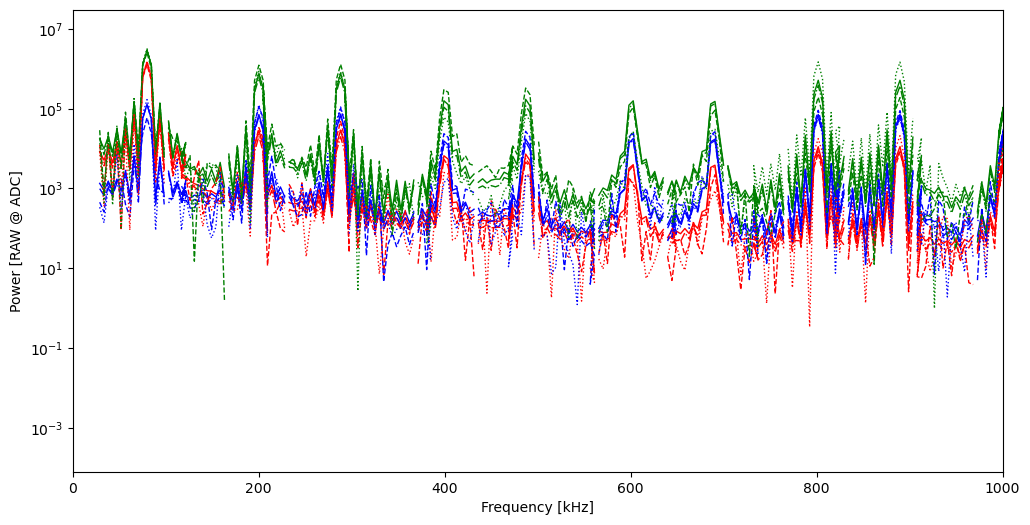

In [17]:
fig = plt.figure(figsize=(12, 6))
ch_min = 0
ch_max = 512
f_min0 = 0
f_max0 = 1000

if spec_mode == 0:
    plt.plot(freq_ave[ch_min:ch_max+1], Eu_ave[ch_min:ch_max+1], '-r', linewidth=1)
    plt.plot(freq_ave[ch_min:ch_max+1], Ev_ave[ch_min:ch_max+1], '-b', linewidth=1)
    plt.plot(freq_ave[ch_min:ch_max+1], Ew_ave[ch_min:ch_max+1], '-g', linewidth=1)
    plt.plot(freq_med[ch_min:ch_max+1], Eu_med[ch_min:ch_max+1], '-.r', linewidth=1)
    plt.plot(freq_med[ch_min:ch_max+1], Ev_med[ch_min:ch_max+1], '-.b', linewidth=1)
    plt.plot(freq_med[ch_min:ch_max+1], Ew_med[ch_min:ch_max+1], '-.g', linewidth=1)

    plt.plot(spec.frequency[ch_min:ch_max+1,0], spec.Eu_power[ch_min:ch_max+1,0], '--r', linewidth=1)
    plt.plot(spec.frequency[ch_min:ch_max+1,0], spec.Ev_power[ch_min:ch_max+1,0], '--b', linewidth=1)
    plt.plot(spec.frequency[ch_min:ch_max+1,0], spec.Ew_power[ch_min:ch_max+1,0], '--g', linewidth=1)
    plt.plot(spec.frequency[ch_min:ch_max+1,n_time-1], spec.Eu_power[ch_min:ch_max+1,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[ch_min:ch_max+1,n_time-1], spec.Ev_power[ch_min:ch_max+1,n_time-1], ':b', linewidth=1)
    plt.plot(spec.frequency[ch_min:ch_max+1,n_time-1], spec.Ew_power[ch_min:ch_max+1,n_time-1], ':g', linewidth=1)
    
else:
    n_samp = np.int16(spec.n_samp * 1.00)
    n_samp = np.int16(spec.n_samp * 0.75)
    n_samp = np.int16(spec.n_samp * 0.66)
    for i in range(spec.n_step):
        if i>=ch_min and i<=ch_max:
            print(freq_ave[i*n_samp:(i+1)*n_samp])
            plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Eu_ave[i*n_samp:(i+1)*n_samp], '-r', linewidth=1)
            plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ev_ave[i*n_samp:(i+1)*n_samp], '-b', linewidth=1)
            plt.plot(freq_ave[i*n_samp:(i+1)*n_samp], Ew_ave[i*n_samp:(i+1)*n_samp], '-g', linewidth=1)
            plt.plot(freq_med[i*n_samp:(i+1)*n_samp], Eu_med[i*n_samp:(i+1)*n_samp], '-.r', linewidth=1)
            plt.plot(freq_med[i*n_samp:(i+1)*n_samp], Ev_med[i*n_samp:(i+1)*n_samp], '-.b', linewidth=1)
            plt.plot(freq_med[i*n_samp:(i+1)*n_samp], Ew_med[i*n_samp:(i+1)*n_samp], '-.g', linewidth=1)

            plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Eu_power[i*n_samp:(i+1)*n_samp,0], '--r', linewidth=1)
            plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ev_power[i*n_samp:(i+1)*n_samp,0], '--b', linewidth=1)
            plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ew_power[i*n_samp:(i+1)*n_samp,0], '--g', linewidth=1)
            plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Eu_power[i*n_samp:(i+1)*n_samp,n_time-1], ':r', linewidth=1)
            plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ev_power[i*n_samp:(i+1)*n_samp,n_time-1], ':b', linewidth=1)
            plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ew_power[i*n_samp:(i+1)*n_samp,n_time-1], ':g', linewidth=1)

plt.xlabel('Frequency [kHz]')
plt.xlim(f_min0, f_max0)

plt.yscale('log')
plt.ylabel(power_str)
# plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec-a.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h-a.png'
# fig.savefig(png_fname)

/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/1606910857.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p1 = ax1.pcolormesh(data.n_data, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/1606910857.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p2 = ax2.pcolormesh(data.n_data, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_78180/160

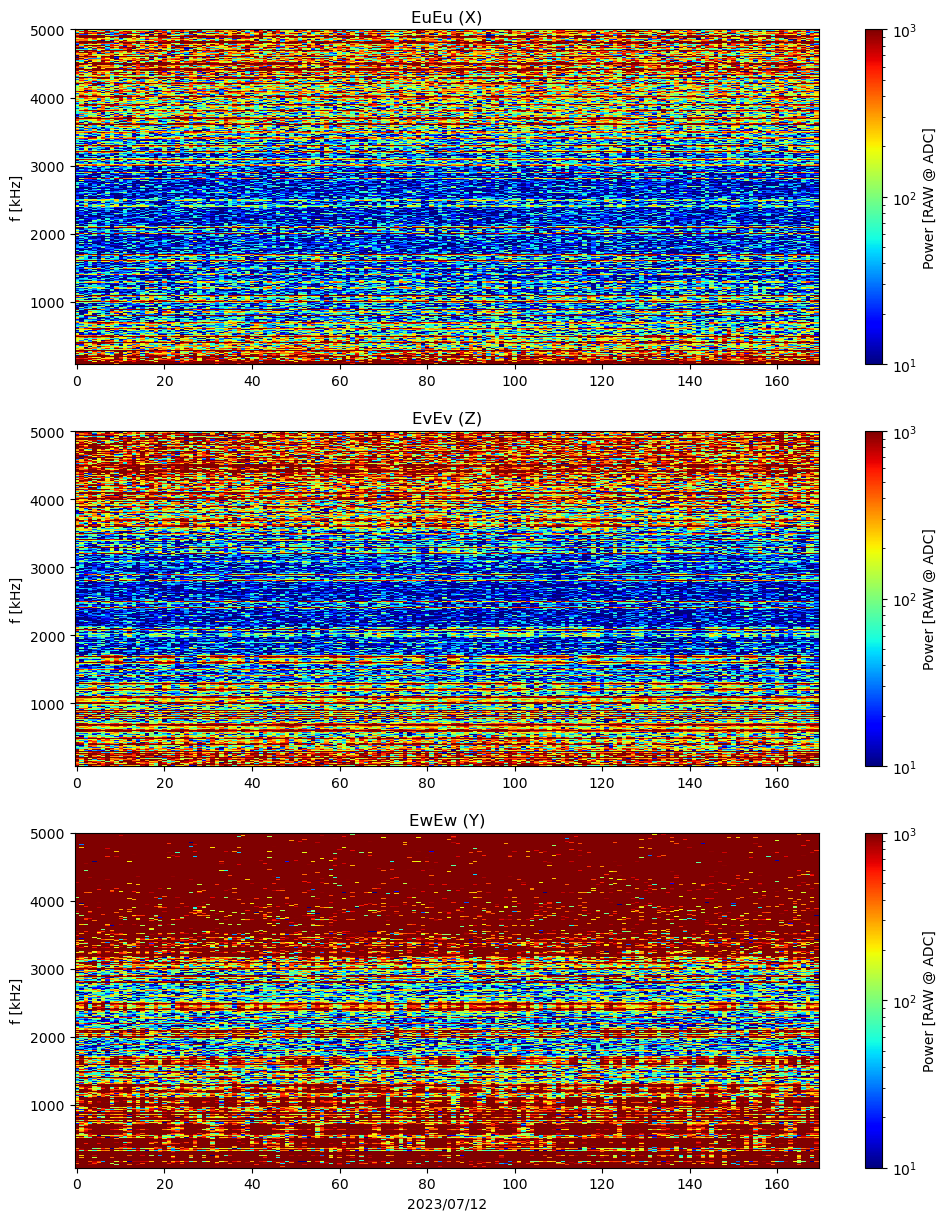

In [15]:
fig = plt.figure(figsize=(12, 20))

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_ylim(80, 5000)
ax2.set_ylim(80, 5000)
ax3.set_ylim(80, 5000)
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
#
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p_min0 = p_min+1
p_max0 = p_max-4

# """
# X: n_data
p1 = ax1.pcolormesh(data.n_data, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(data.n_data, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p3 = ax3.pcolormesh(data.n_data, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
"""
# X: EPOCH
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
"""

# colbar
pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

"""
# if X: n_data
ax4 = fig.add_subplot(4, 1, 4)
p4 = ax4.plot(data.n_data, data.epoch, '-b', linewidth=1)
ax4.set_xlim(0, len(data.n_data))
# pp4 = fig.colorbar(p4, ax=ax4, orientation="vertical")
# pp4.set_label(power_str)
"""

png_fname = work_dir+data_name+'_FT-log-a.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h-a.png'
# fig.savefig(png_fname)

2023/07/12


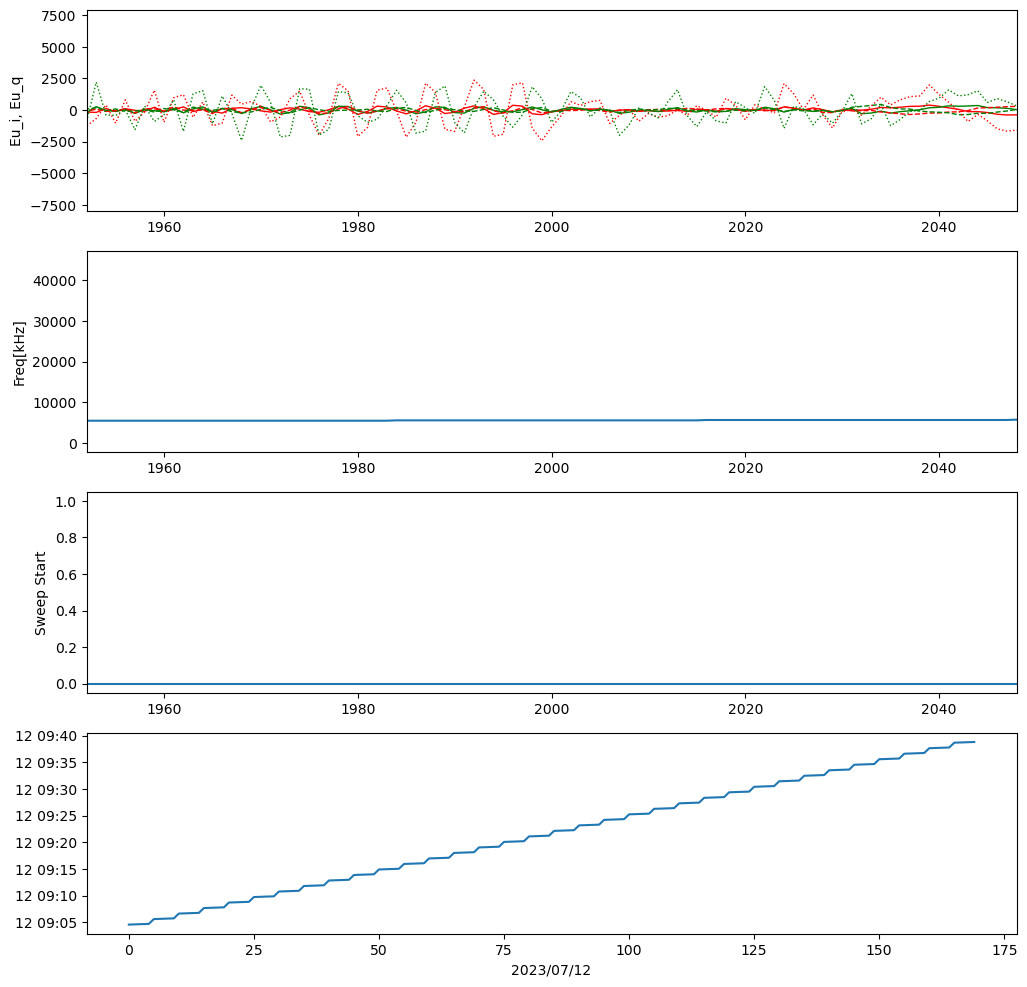

In [16]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(data.Eu_i), '-r', linewidth=1)
ax1.plot(np.ravel(data.Eu_q), '-g', linewidth=1)
ax1.plot(np.ravel(data.Ev_i), '--r', linewidth=1)
ax1.plot(np.ravel(data.Ev_q), '--g', linewidth=1)
ax1.plot(np.ravel(data.Ew_i), ':r', linewidth=1)
ax1.plot(np.ravel(data.Ew_q), ':g', linewidth=1)
ax2.plot(np.ravel(data.frequency))
ax3.plot(np.ravel(data.sweep_start))
ax4.plot(np.ravel(data.n_data), np.ravel(data.epoch))
# ax4.plot(np.ravel(data.n_data))
# ax4.plot(np.ravel(data.epoch))
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
print(date)

ax1.set_ylabel('Eu_i, Eu_q')
ax2.set_ylabel('Freq[kHz]')
ax3.set_ylabel('Sweep Start')
ax4.set_xlabel(date)

xlim=[1952, 2048]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_xlim(xlim)
plt.show()
png_fname = work_dir+data_name+'_raw-a.png'
# fig.savefig(png_fname)
